In [7]:
from __future__ import annotations
from pathlib import Path
from typing import Dict, Tuple, List
from typing import Iterable, Iterator, Optional, List
import os
import json
import pandas as pd
import numpy as np
from loguru import logger
import datetime as dt

In [8]:
BASE_DIR = os.getcwd()
HOME_DIR = os.path.dirname(BASE_DIR)
new_data_dates = os.listdir(os.path.join(HOME_DIR, "hl-node-fills"))

# Config/paths
DATA_DIR = Path(os.path.join(HOME_DIR, "data"))
DATA_DIR.mkdir(parents=True, exist_ok=True)

WALLETS_CSV = DATA_DIR / "wallet_db.csv"
def _fix_pyarrow_period_double_registration():
    try:
        import pyarrow as pa
        try:
            pa.unregister_extension_type("pandas.period")
        except Exception:
            pass
    except Exception:
        pass

_SCHEMA = {
    "price": "float32",
    "size": "float32",
    "time": "datetime64[ns]",
    "is_ask": "bool",
    "wallet_id": "uint32",
}

class CoinDataStore:
    def __init__(self, coin: str, base_dir: Path | str = DATA_DIR):
        self.coin = str(coin)
        self.base_dir = Path(base_dir)
        self.coin_dir = self.base_dir / self.coin

    # ---------- Paths & listing ----------
    def day_path(self, day: dt.date | str) -> Path:
        if isinstance(day, str):
            day = dt.date.fromisoformat(day)  # 'YYYY-MM-DD'
        return self.coin_dir / f"{day}.parquet"

    def list_days(self) -> List[dt.date]:
        if not self.coin_dir.exists():
            return []
        days = []
        for name in os.listdir(self.coin_dir):
            if not name.endswith(".parquet"):
                continue
            try:
                d = dt.date.fromisoformat(name[:-8])  # strip '.parquet'
                days.append(d)
            except ValueError:
                logger.warning(f"Skipping unexpected file in {self.coin_dir}: {name}")
        days.sort()
        return days

    # Core readers
    def _read_one_day(self, path: Path) -> pd.DataFrame:
        if not path.exists():
            return pd.DataFrame(columns=list(_SCHEMA.keys()))
        _fix_pyarrow_period_double_registration()
        df = pd.read_parquet(path, engine="pyarrow")

        if "time" in df.columns:
            df["time"] = pd.to_datetime(df["time"], errors="coerce")
        for col, dtype in _SCHEMA.items():
            if col not in df.columns:
                df[col] = pd.Series(dtype=dtype)
                
        for col, dtype in _SCHEMA.items():
            if col == "time":
                continue
            try:
                df[col] = df[col].astype(dtype, copy=False)
            except Exception as e:
                logger.warning(f"Column {col} cast to {dtype} failed in {path.name}: {e}")
                df[col] = pd.to_numeric(df[col], errors="coerce") if "float" in dtype else df[col]
                try:
                    df[col] = df[col].astype(dtype, copy=False)
                except Exception:
                    pass

        df = df[["price", "size", "time", "is_ask", "wallet_id"]]
        df = df.dropna(subset=["time"])
        return df

    def _finalize(self, df: pd.DataFrame) -> pd.DataFrame:
        if df.empty:
            return df.astype(_SCHEMA)
            
        df = df.drop_duplicates(subset=["time", "wallet_id", "price", "size", "is_ask"], keep="last")
        df = df.sort_values("time")
        
        df["price"] = df["price"].astype("float32")
        df["size"] = df["size"].astype("float32")
        df["is_ask"] = df["is_ask"].astype("bool")
        df["wallet_id"] = df["wallet_id"].astype("uint32")
        return df

    # APIs
    def load_all(self) -> pd.DataFrame:
        """Load and combine all available days for this coin."""
        days = self.list_days()
        if not days:
            return pd.DataFrame(columns=list(_SCHEMA.keys())).astype(_SCHEMA)
        parts = [self._read_one_day(self.day_path(d)) for d in days]
        return self._finalize(pd.concat(parts, ignore_index=True)) if parts else self._finalize(pd.DataFrame())

    def load_between(
        self,
        start: dt.date | str | None = None,
        end: dt.date | str | None = None,
        inclusive: str = "both",
    ) -> pd.DataFrame:
        
        avail = self.list_days()
        if not avail:
            return pd.DataFrame(columns=list(_SCHEMA.keys())).astype(_SCHEMA)

        if isinstance(start, str): start = dt.date.fromisoformat(start)
        if isinstance(end, str):   end = dt.date.fromisoformat(end)

        lo = start if start else avail[0]
        hi = end if end else avail[-1]

        def in_range(d: dt.date) -> bool:
            if inclusive in ("both", "left"):
                left_ok = d >= lo
            else:
                left_ok = d > lo
            if inclusive in ("both", "right"):
                right_ok = d <= hi
            else:
                right_ok = d < hi
            return left_ok and right_ok

        selected = [d for d in avail if in_range(d)]
        if not selected:
            return pd.DataFrame(columns=list(_SCHEMA.keys())).astype(_SCHEMA)

        parts = [self._read_one_day(self.day_path(d)) for d in selected]
        return self._finalize(pd.concat(parts, ignore_index=True))

    def load_days(self, days: Iterable[dt.date | str]) -> pd.DataFrame:
        paths = []
        for d in days:
            if isinstance(d, str):
                d = dt.date.fromisoformat(d)
            paths.append(self.day_path(d))
        parts = [self._read_one_day(p) for p in paths]
        return self._finalize(pd.concat(parts, ignore_index=True) if parts else pd.DataFrame())

    def iter_days(self, start: Optional[dt.date | str] = None, end: Optional[dt.date | str] = None) -> Iterator[pd.DataFrame]:
        avail = self.list_days()
        if not avail:
            return
        if isinstance(start, str): start = dt.date.fromisoformat(start)
        if isinstance(end, str):   end = dt.date.fromisoformat(end)
        lo = start if start else avail[0]
        hi = end if end else avail[-1]
        for d in avail:
            if d < lo or d > hi:
                continue
            yield self._finalize(self._read_one_day(self.day_path(d)))

In [9]:
store = CoinDataStore("ETH")

# 1) Everything
df_all = store.load_all()

In [10]:
import sys
sys.getsizeof(df_all) / 10**6

1533.590792

                      value
n_trades      26,425,855.00
total_volume  95,228,512.00
vwap               2,446.85
price_min          1,382.30
price_max          3,862.60
price_mean         2,536.22
price_median       2,529.10
price_std            609.06
size_min               0.00
size_max           7,360.01
size_mean              3.60
size_median            0.34
size_std              15.02
size_p50               0.34
size_p90               8.38
size_p99              53.90


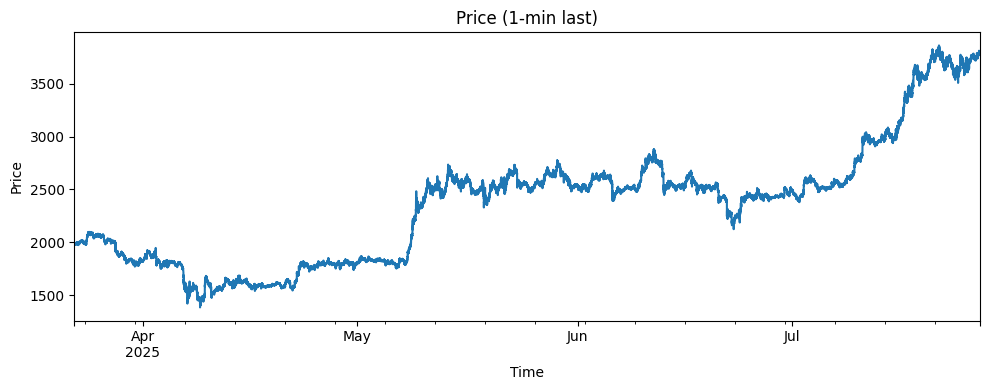

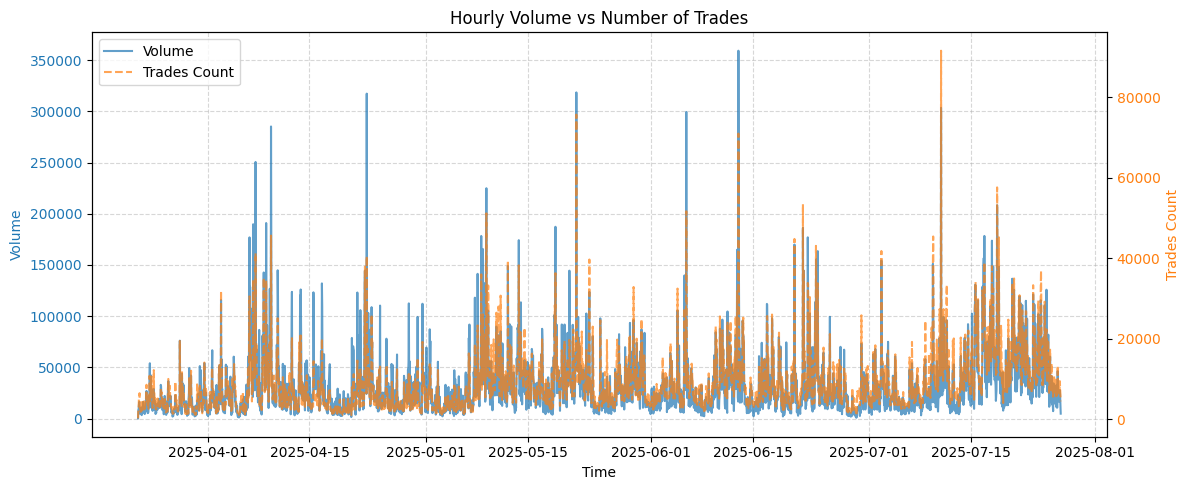

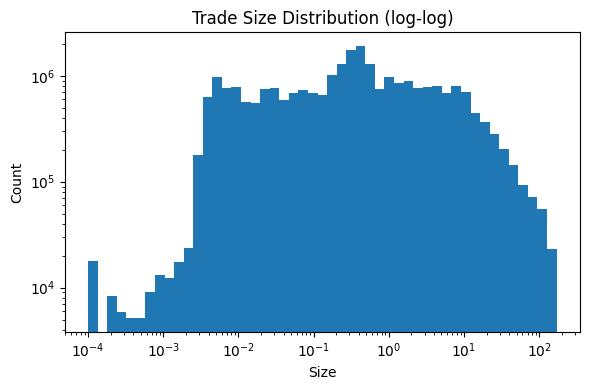

In [11]:
# prerequisites
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TRADE-LEVEL VIEW
trades = df_all[df_all["is_ask"]].copy()
trades = trades.sort_values("time")
trades["notional"] = trades["price"] * trades["size"]

# BASIC STATS
n_trades = len(trades)
tot_vol  = trades["size"].sum()
vwap     = trades["notional"].sum() / max(tot_vol, 1e-12)

price_stats = trades["price"].agg(["min","max","mean","median","std"])
size_stats  = trades["size"].agg(["min","max","mean","median","std"])
size_pct    = trades["size"].quantile([0.5, 0.9, 0.99]).rename({0.5:"p50",0.9:"p90",0.99:"p99"})

summary = {
    "n_trades": n_trades,
    "total_volume": tot_vol,
    "vwap": vwap,
    "price_min": price_stats["min"],
    "price_max": price_stats["max"],
    "price_mean": price_stats["mean"],
    "price_median": price_stats["median"],
    "price_std": price_stats["std"],
    "size_min": size_stats["min"],
    "size_max": size_stats["max"],
    "size_mean": size_stats["mean"],
    "size_median": size_stats["median"],
    "size_std": size_stats["std"],
    "size_p50": size_pct["p50"],
    "size_p90": size_pct["p90"],
    "size_p99": size_pct["p99"],
}

summary_df = pd.Series(summary).to_frame("value")
summary_df["value"] = summary_df["value"].apply(lambda x: f"{x:,.2f}")
print(summary_df)


# TIME BUCKETS (1m + 1h)
trades_min = (
    trades.set_index("time")
          .groupby(pd.Grouper(freq="1min"))
          .agg(
              last_price=("price","last"),
              volume=("size","sum"),
              notional=("notional","sum")
          )
)
trades_min["vwap"] = trades_min["notional"] / trades_min["volume"].where(trades_min["volume"]>0, np.nan)
trades_min["last_price"] = trades_min["last_price"].ffill()  # keep price series continuous

trades_hr = (
    trades.set_index("time")
          .groupby(pd.Grouper(freq="1h"))
          .agg(
              last_price=("price","last"),
              volume=("size","sum"),
              notional=("notional","sum")
          )
)
trades_hr["vwap"] = trades_hr["notional"] / trades_hr["volume"].where(trades_hr["volume"]>0, np.nan)
trades_hr["last_price"] = trades_hr["last_price"].ffill()


# PLOTS
# 1) Price (1-min last) over time
plt.figure(figsize=(10,4))
trades_min["last_price"].plot()
plt.title("Price (1-min last)")
plt.xlabel("Time"); plt.ylabel("Price")
plt.tight_layout(); plt.show()

# 2) Volume per hour
trades_hr = (
    trades.set_index("time")
          .groupby(pd.Grouper(freq="1h"))
          .agg(
              last_price=("price","last"),
              volume=("size","sum"),
              notional=("notional","sum"),
              n_trades=("size","count")   # <-- count of trades
          )
)
trades_hr["vwap"] = trades_hr["notional"] / trades_hr["volume"].where(trades_hr["volume"]>0, np.nan)
trades_hr["last_price"] = trades_hr["last_price"].ffill()


fig, ax1 = plt.subplots(figsize=(12,5))

# Volume line
ax1.plot(trades_hr.index, trades_hr["volume"], color="tab:blue", label="Volume", linewidth=1.5, alpha=0.7)
ax1.set_xlabel("Time")
ax1.set_ylabel("Volume", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.grid(True, linestyle="--", alpha=0.5)

# Trade count line (secondary axis)
ax2 = ax1.twinx()
ax2.plot(trades_hr.index, trades_hr["n_trades"], color="tab:orange", label="Trades Count", linewidth=1.5, alpha=0.7, linestyle="--")
ax2.set_ylabel("Trades Count", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.title("Hourly Volume vs Number of Trades")
plt.tight_layout()
plt.show()


# 2.1 Volume bars
trades_hr = (
    trades.set_index("time")
          .groupby(pd.Grouper(freq="1h"))
          .agg(
              last_price=("price","last"),
              volume=("size","sum"),
              notional=("notional","sum"),
              n_trades=("size","count")   # <-- count of trades
          )
)
trades_hr["vwap"] = trades_hr["notional"] / trades_hr["volume"].where(trades_hr["volume"]>0, np.nan)
trades_hr["last_price"] = trades_hr["last_price"].ffill()


fig, ax1 = plt.subplots(figsize=(12,5))

# Volume line
ax1.plot(trades_hr.index, trades_hr["volume"], color="tab:blue", label="Volume", linewidth=1.5, alpha=0.7)
ax1.set_xlabel("Time")
ax1.set_ylabel("Volume", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.grid(True, linestyle="--", alpha=0.5)

# Trade count line (secondary axis)
ax2 = ax1.twinx()
ax2.plot(trades_hr.index, trades_hr["n_trades"], color="tab:orange", label="Trades Count", linewidth=1.5, alpha=0.7, linestyle="--")
ax2.set_ylabel("Trades Count", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.title("Hourly Volume vs Number of Trades")
plt.tight_layout()
plt.show()



# 3) Trade size distribution (log-log histogram)
plt.figure(figsize=(6,4))
# log scale to avoid memory spikes
sizes = trades["size"].to_numpy()
sizes = sizes[sizes > 0]
bins = np.logspace(np.log10(sizes.min()), np.log10(np.percentile(sizes, 99.9)), 50)
plt.hist(sizes, bins=bins)
plt.xscale("log"); plt.yscale("log")
plt.title("Trade Size Distribution (log-log)")
plt.xlabel("Size"); plt.ylabel("Count")
plt.tight_layout(); plt.show()


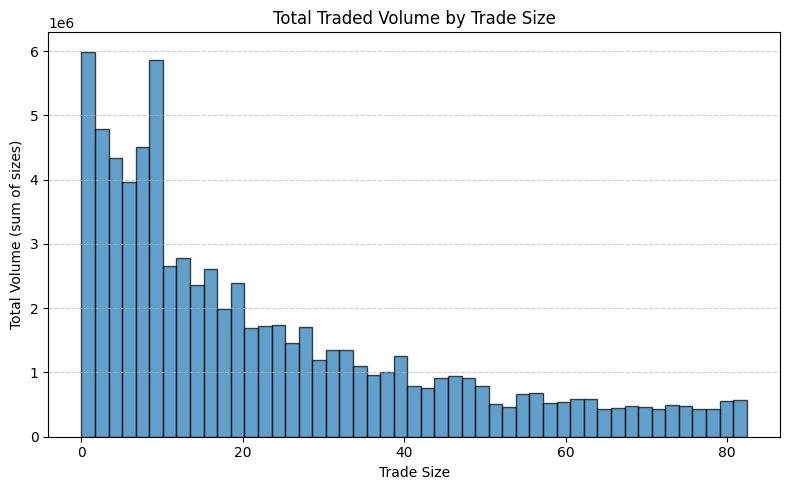

In [12]:
import numpy as np
import matplotlib.pyplot as plt

sizes = trades["size"].to_numpy()
sizes = sizes[sizes > 0]

bins = np.linspace(sizes.min(), np.percentile(sizes, 99.5), 50)
volumes, edges = np.histogram(sizes, bins=bins, weights=sizes)
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# Plot
plt.figure(figsize=(8,5))
plt.bar(bin_centers, volumes, width=np.diff(edges), align="center", alpha=0.7, edgecolor="black")
plt.title("Total Traded Volume by Trade Size")
plt.xlabel("Trade Size")
plt.ylabel("Total Volume (sum of sizes)")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()



Top 10 wallets by traded volume:
            Trades   Total Volume Sell Share    Trades/Day
wallet_id                                                 
548        1357955  11,690,130.00      50.0%  10692.559055
6668       1044591  11,633,425.00      49.9%   8356.728000
826        1764250   7,758,599.50      50.1%  13891.732283
38          516604   5,020,350.50      50.1%   4067.748031
48          340721   4,206,872.00      50.0%   2770.089431
116         333147   3,390,841.25      50.1%   2623.204724
644         296066   2,666,999.00      50.0%   2331.228346
15          200943   2,469,263.50      50.0%   1582.228346
96          134174   2,284,451.00      50.0%   1056.488189
6569        406074   2,182,392.00      49.9%   7383.163636


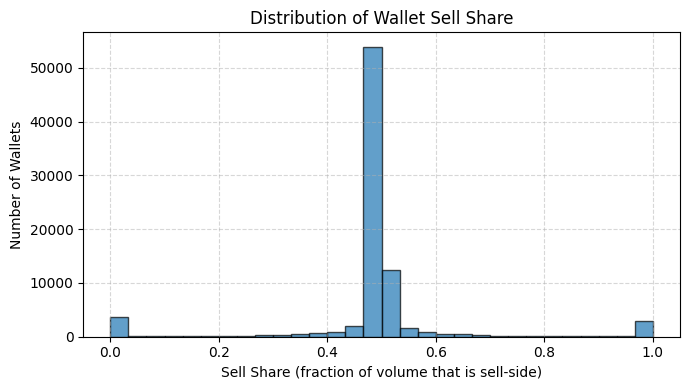

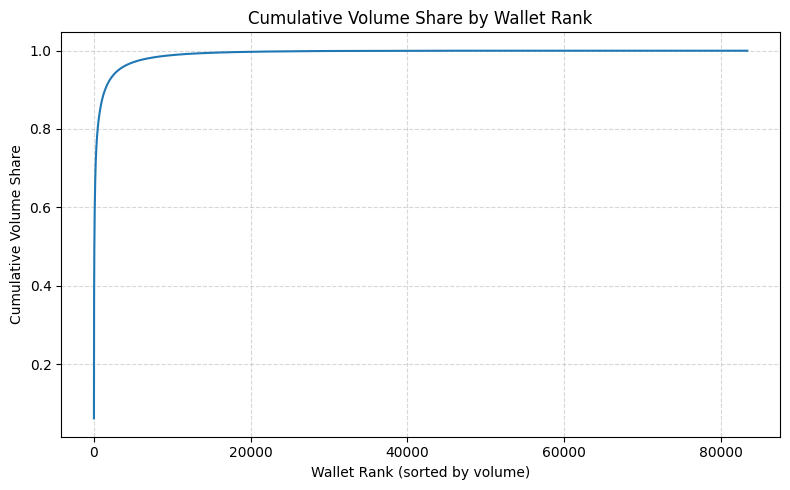

In [13]:
import numpy as np
import pandas as pd

# Ensure types
df_all["time"] = pd.to_datetime(df_all["time"], utc=True)

# Per-wallet aggregates
wallet_stats = (
    df_all
    .groupby("wallet_id")
    .agg(
        n_trades=("size", "count"),
        total_volume=("size", "sum"),
        avg_size=("size", "mean"),
        size_p50=("size", lambda x: np.percentile(x, 50)),
        size_p90=("size", lambda x: np.percentile(x, 90)),
        size_p99=("size", lambda x: np.percentile(x, 99)),
        buy_volume=("size", lambda x: x[~df_all.loc[x.index, "is_ask"]].sum()),
        sell_volume=("size", lambda x: x[df_all.loc[x.index, "is_ask"]].sum()),
        first_trade=("time", "min"),
        last_trade=("time", "max"),
    )
)

wallet_stats["sell_share"] = wallet_stats["sell_volume"] / wallet_stats["total_volume"]
wallet_stats["active_days"] = (wallet_stats["last_trade"] - wallet_stats["first_trade"]).dt.days + 1
wallet_stats["trades_per_day"] = wallet_stats["n_trades"] / wallet_stats["active_days"]

# Concentration
# Share of total volume per wallet
wallet_stats["volume_share"] = wallet_stats["total_volume"] / wallet_stats["total_volume"].sum()

# Top wallets
top_wallets = wallet_stats.sort_values("total_volume", ascending=False).head(10).copy()

# Formatting
top_wallets["total_volume_fmt"] = top_wallets["total_volume"].map(lambda x: f"{x:,.2f}")
top_wallets["sell_share_fmt"] = top_wallets["sell_share"].map(lambda x: f"{x:.1%}")

# Display selected + formatted columns
print("\nTop 10 wallets by traded volume:")
print(
    top_wallets[["n_trades", "total_volume_fmt", "sell_share_fmt", "trades_per_day"]]
    .rename(columns={
        "n_trades": "Trades",
        "total_volume_fmt": "Total Volume",
        "sell_share_fmt": "Sell Share",
        "trades_per_day": "Trades/Day"
    })
)


# Plots
import matplotlib.pyplot as plt

# Histogram of sell share
plt.figure(figsize=(7,4))
wallet_stats["sell_share"].dropna().plot.hist(bins=30, alpha=0.7, edgecolor="black")
plt.title("Distribution of Wallet Sell Share")
plt.xlabel("Sell Share (fraction of volume that is sell-side)")
plt.ylabel("Number of Wallets")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Wallet concentration plot (Pareto-style)
plt.figure(figsize=(8,5))
wallet_stats_sorted = wallet_stats.sort_values("total_volume", ascending=False)
wallet_stats_sorted["cum_volume_share"] = wallet_stats_sorted["total_volume"].cumsum() / wallet_stats_sorted["total_volume"].sum()
wallet_stats_sorted["cum_volume_share"].reset_index(drop=True).plot()
plt.title("Cumulative Volume Share by Wallet Rank")
plt.xlabel("Wallet Rank (sorted by volume)")
plt.ylabel("Cumulative Volume Share")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


/tmp/ipykernel_8103/3376933145.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .groupby(pd.Grouper(freq="1H"))


Annualized realized volatility (hourly): 0.7171
Annualized realized volatility (daily): 0.7640


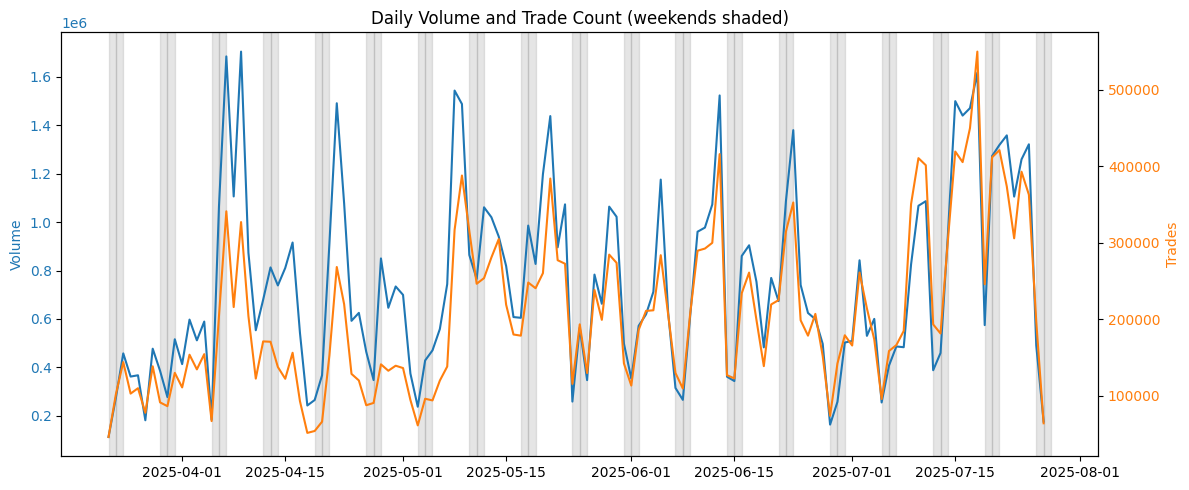

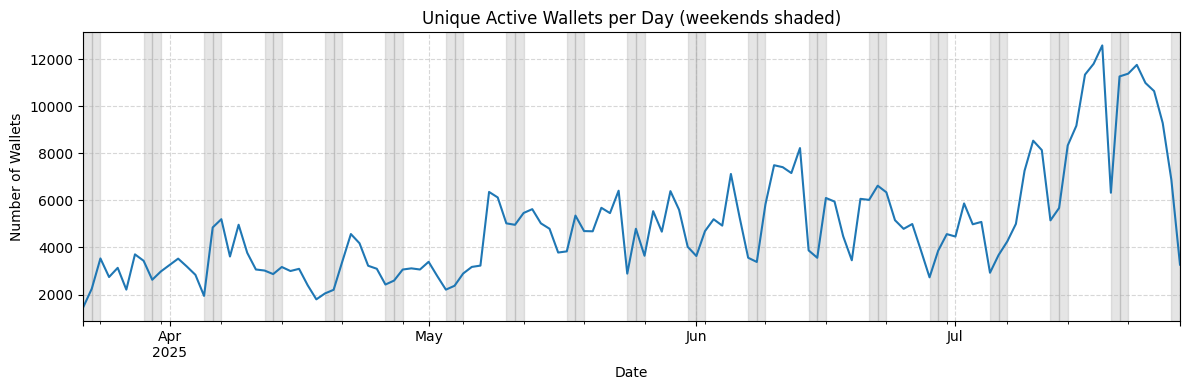

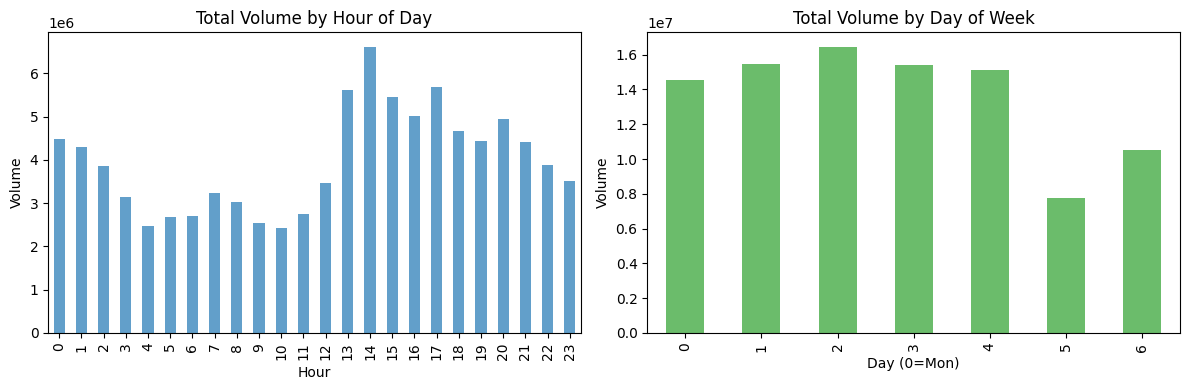

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Deduped trade-level view
trades = df_all[df_all["is_ask"]].copy()
trades["time"] = pd.to_datetime(trades["time"], utc=True)
trades = trades.sort_values("time")
trades["notional"] = trades["price"] * trades["size"]

# Hourly and Daily Aggregates
trades_hr = (
    trades.set_index("time")
          .groupby(pd.Grouper(freq="1H"))
          .agg(
              n_trades=("size","count"),
              volume=("size","sum"),
              notional=("notional","sum"),
              last_price=("price","last")
          )
)
trades_hr["vwap"] = trades_hr["notional"] / trades_hr["volume"].where(trades_hr["volume"]>0, np.nan)
trades_hr["last_price"] = trades_hr["last_price"].ffill()

trades_day = (
    trades.set_index("time")
          .groupby(pd.Grouper(freq="1D"))
          .agg(
              n_trades=("size","count"),
              volume=("size","sum"),
              notional=("notional","sum"),
              last_price=("price","last")
          )
)
trades_day["vwap"] = trades_day["notional"] / trades_day["volume"].where(trades_day["volume"]>0, np.nan)
trades_day["last_price"] = trades_day["last_price"].ffill()

# Volatility
logret_hr = np.log(trades_hr["last_price"]).diff()
vol_hr = logret_hr.std(skipna=True) * np.sqrt(24*365)  # annualized
print(f"Annualized realized volatility (hourly): {vol_hr:.4f}")

logret_day = np.log(trades_day["last_price"]).diff()
vol_day = logret_day.std(skipna=True) * np.sqrt(365)
print(f"Annualized realized volatility (daily): {vol_day:.4f}")

# Active wallets per day
active_wallets_day = (
    df_all.groupby(df_all["time"].dt.floor("1D"))["wallet_id"]
          .nunique()
          .rename("unique_wallets")
)



# Seasonality: hour of day / day of week
trades["hour"] = trades["time"].dt.hour
trades["dow"] = trades["time"].dt.dayofweek  # 0=Monday

hourly_pattern = trades.groupby("hour")["size"].sum()
dow_pattern = trades.groupby("dow")["size"].sum()


# PLOTS

# Daily volume and trades
fig, ax1 = plt.subplots(figsize=(12,5))

ax1.plot(trades_day.index, trades_day["volume"], color="tab:blue", label="Volume")
ax1.set_ylabel("Volume", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot(trades_day.index, trades_day["n_trades"], color="tab:orange", label="Trades")
ax2.set_ylabel("Trades", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

# Highlight weekends
for day in trades_day.index:
    if day.weekday() >= 5:  # Saturday=5, Sunday=6
        ax1.axvspan(day, day + pd.Timedelta(days=1),
                    color="gray", alpha=0.2)

ax1.set_title("Daily Volume and Trade Count (weekends shaded)")
fig.tight_layout()
plt.show()


# Active wallets per day
fig, ax = plt.subplots(figsize=(12,4))

active_wallets_day.plot(ax=ax, color="tab:blue")

# Highlight weekends (shade Sat & Sun)
for day in active_wallets_day.index:
    if day.weekday() >= 5:  # Saturday=5, Sunday=6
        ax.axvspan(day, day + pd.Timedelta(days=1),
                   color="gray", alpha=0.2)

ax.set_title("Unique Active Wallets per Day (weekends shaded)")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Wallets")
ax.grid(True, linestyle="--", alpha=0.5)

fig.tight_layout()
plt.show()



# Seasonality (hour of day / day of week)
fig, axes = plt.subplots(1,2,figsize=(12,4))
hourly_pattern.plot(kind="bar", ax=axes[0], color="tab:blue", alpha=0.7)
axes[0].set_title("Total Volume by Hour of Day")
axes[0].set_xlabel("Hour"); axes[0].set_ylabel("Volume")
dow_pattern.plot(kind="bar", ax=axes[1], color="tab:green", alpha=0.7)
axes[1].set_title("Total Volume by Day of Week")
axes[1].set_xlabel("Day (0=Mon)"); axes[1].set_ylabel("Volume")
plt.tight_layout(); plt.show()


In [15]:
# Separate asks and bids
asks = df_all[df_all["is_ask"]].rename(columns={"wallet_id": "seller"})
bids = df_all[~df_all["is_ask"]].rename(columns={"wallet_id": "buyer"})

# Merge on (time, price, size) to link buyer <-> seller
# (assumes uniqueness within trade-level granularity)
pairs = pd.merge(
    asks[["time","price","size","seller"]],
    bids[["time","price","size","buyer"]],
    on=["time","price","size"]
)

print(pairs.head())


                                 time        price    size  seller  buyer
0 2025-03-22 10:50:22.049676014+00:00  1996.500000  0.0062      81     82
1 2025-03-22 10:50:22.049676014+00:00  1996.500000  0.0075      81     82
2 2025-03-22 10:50:22.049676014+00:00  1996.500000  8.0000      83     82
3 2025-03-22 10:50:22.930512310+00:00  1996.500000  0.2212      98     48
4 2025-03-22 10:50:23.052200940+00:00  1996.199951  0.0100     110    108


In [ ]:
import pandas as pd
import numpy as np

# Ensure proper types
df_all["time"] = pd.to_datetime(df_all["time"], utc=True)

# Get index of seller (is_ask=True) and buyer (is_ask=False) for each trade key
grp = df_all.groupby(["time","price","size"], sort=False)["is_ask"]
idx_seller = grp.idxmax()   # row where is_ask is True
idx_buyer  = grp.idxmin()   # row where is_ask is False

pairs = pd.DataFrame({
    "time": df_all.loc[idx_seller, "time"].to_numpy(),
    "price": df_all.loc[idx_seller, "price"].to_numpy(),
    "size":  df_all.loc[idx_seller, "size"].to_numpy(),
    "seller": df_all.loc[idx_seller, "wallet_id"].to_numpy(),
    "buyer":  df_all.loc[idx_buyer,  "wallet_id"].to_numpy(),
}).sort_values("time").reset_index(drop=True)

# Quick sanity / tiny memory:
# pairs uses only 5 columns; with ~N/2 rows it’s much smaller than df_all.

In [ ]:
self_trades = pairs[pairs["seller"] == pairs["buyer"]]
print(f"Self-trades: {len(self_trades):,}")

In [ ]:
from collections import deque, defaultdict

# Params (tune as you like)
TIME_WINDOW = pd.Timedelta("5min")
SIZE_TOL_REL = 0.05   # 5% size tolerance
PRICE_TOL_REL = 0.002 # 0.2% price tolerance

# For each directional pair we keep recent trades in a deque:
# cache[(seller,buyer)] = deque of (time, size, price)
cache = defaultdict(deque)

roundtrip_hits = []

for row in pairs.itertuples(index=False):
    t = row.time; a = row.seller; b = row.buyer; sz = row.size; px = row.price

    # 1) purge old entries in BOTH directions to keep memory bounded
    cutoff = t - TIME_WINDOW
    for dq in (cache[(a,b)], cache[(b,a)]):
        while dq and dq[0][0] < cutoff:
            dq.popleft()

    # 2) check reverse side (b->a) for a recent match
    dq_rev = cache[(b,a)]
    # Scan recent reverse events from newest to oldest (few items per window)
    for (t2, sz2, px2) in reversed(dq_rev):
        if (abs(sz2 - sz) <= SIZE_TOL_REL * max(sz, sz2)) and \
           (abs(px2 - px) <= PRICE_TOL_REL * max(px, px2)):
            roundtrip_hits.append((t2, t, b, a, sz2, px2, a, b, sz, px))
            break  # one match is enough; comment out if you want multiple

    # 3) push current trade to cache for (a->b)
    cache[(a,b)].append((t, sz, px))

# Results as DataFrame
roundtrips = pd.DataFrame(roundtrip_hits, columns=[
    "t_rev","t_fwd","seller_rev","buyer_rev","size_rev","price_rev",
    "seller_fwd","buyer_fwd","size_fwd","price_fwd"
])
print(f"Round-trips detected (≤{TIME_WINDOW}): {len(roundtrips):,}")


In [ ]:
# Total volume by pair (direction-agnostic)
pair_vol = (
    pd.concat([
        pairs[["seller","buyer","size"]],
        pairs.rename(columns={"seller":"buyer","buyer":"seller"})[["seller","buyer","size"]],
    ], ignore_index=True)
    .groupby(["seller","buyer"], sort=False)["size"].sum()
)

# For each wallet, share of volume with its top counterparty
wallet_tot = pair_vol.groupby(level=0).sum()
top_share = (pair_vol.groupby(level=0).max() / wallet_tot).sort_values(ascending=False)

print("\nTop 20 wallets by counterparty dominance (share of their volume with a single counterparty):")
print(top_share.head(20).to_frame("top_counterparty_share"))


In [ ]:
import matplotlib.pyplot as plt

# Round-trip latency distribution (seconds)
if not roundtrips.empty:
    lat_s = (roundtrips["t_fwd"] - roundtrips["t_rev"]).dt.total_seconds()
    plt.figure(figsize=(7,4))
    plt.hist(lat_s, bins=50)
    plt.title("Round-trip latency (seconds)")
    plt.xlabel("Seconds"); plt.ylabel("Count")
    plt.tight_layout(); plt.show()

# Counterparty dominance histogram
plt.figure(figsize=(7,4))
top_share.clip(upper=1).plot(kind="hist", bins=30, edgecolor="black", alpha=0.7)
plt.title("Distribution of top counterparty share per wallet")
plt.xlabel("Share"); plt.ylabel("Wallets")
plt.tight_layout(); plt.show()
